In [ ]:
# 1. Сколько у нас пользователей, которые совершили покупку только один раз?
# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)
# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
# 5. Используя pandas, проведи когортный анализ пользователей. 
# В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.
# 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

In [214]:

import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-fi-bochko/olist_customers_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-fi-bochko/olist_order_items_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-fi-bochko/olist_orders_dataset.csv')


In [215]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [216]:
# Обединяем таблицы с заказами и клиентами

merged_df = pd.merge(orders, customers, on='customer_id')
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [217]:
# фильтруем по успешным заказам, считаем количество заказов для каждого клиента, сортируем 
# Оставляем только тех, у кого был один заказ

q1 = merged_df.query('order_status=="delivered"').groupby(['customer_unique_id']) \
.agg(orders_amount=('order_status', 'count')).sort_values('orders_amount')
q11 = q1.query('orders_amount==1')
q11

,orders_amount
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
a942d415001f36acf150dca4a627f6aa,1
a942ba2a7bed631c5d4ec4d756b9df90,1
a942204dbe5292ccb73d3171b6d03d54,1
a941c257a51188577ec66ddbeee21403,1
...,...
428f23ed853b49c314e54eedc7c0d251,1
5513ea33a42a77b2dcbc2691ad56557a,1
55bccecaaf1999c1d049ad6f48190bc6,1


# Ответ: 90557 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [218]:

# Переводим столбцы с датами в datetime


orders.order_purchase_timestamp = pd.to_datetime(orders['order_purchase_timestamp'])
orders.order_approved_at = pd.to_datetime(orders['order_approved_at'])
orders.order_delivered_carrier_date = pd.to_datetime(orders['order_delivered_carrier_date'])
orders.order_delivered_customer_date = pd.to_datetime(orders['order_delivered_customer_date'])
orders.order_estimated_delivery_date = pd.to_datetime(orders['order_estimated_delivery_date'])


In [219]:
# Оставляем два нужных стобца
# Фильтруем по не состоявшимся заказам
# Группируем по дате создания заказа
# создаем колонку с количеством для дальнейшего подсчета среднего 

q2 = orders[['order_status', 'order_purchase_timestamp']] \
.query('order_status == "unavailable" or order_status == "canceled"') \
.groupby(['order_purchase_timestamp', 'order_status'], as_index=False) \
.agg(count=('order_status', 'count')).sort_values('order_status') \

q2.head()

,order_purchase_timestamp,order_status,count
0,2016-09-05 00:15:34,canceled,1
839,2018-02-02 09:09:27,canceled,1
840,2018-02-02 15:29:05,canceled,1
841,2018-02-02 16:06:44,canceled,1
842,2018-02-02 17:42:31,canceled,1


In [220]:
#  Переименовываю колонку с датой
#  Оставляю в колонке с датой только месяц и год
#  Считаю сумму покупок в каждый месяц с разбивкой по причинам

q21 = q2.rename(columns={'order_purchase_timestamp': 'date'})
q21['date'] = q21['date'].dt.to_period('M')
q21 = q21.groupby(['date', 'order_status'], as_index=False).agg({'count': 'sum'})
q21.head()

,date,order_status,count
0,2016-09,canceled,2
1,2016-10,canceled,24
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10


In [221]:
# Проверяю, все ли месяцы попали в список
orders_t = orders.sort_values('order_purchase_timestamp')
orders_t['t'] = orders_t['order_purchase_timestamp'].dt.to_period('M')
orders_t = orders_t['t'].unique()
orders_t

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08', '2018-09', '2018-10']
Length: 25, dtype: period[M]

# Ответ:

In [222]:
# Считаем среднее значение. Ответ:

mean_month_failed = q21.groupby('order_status').agg(mean=('count', 'mean'))
mean_month_failed

,mean
order_status,
canceled,26.041667
unavailable,29.000000


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 


In [223]:
# Объединяю таблицы с заказами и продуктами

merged_df_3 = pd.merge(orders, items, on='order_id')
merged_df_3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [224]:
# Оставляем нужные столбцы, создаем колонку с днем недели

q3 = merged_df_3[['product_id', 'order_approved_at']]
q3['day_of_week'] = q3['order_approved_at'].dt.strftime('%A')
q3

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,product_id,order_approved_at,day_of_week
0,87285b34884572647811a353c7ac498a,2017-10-02 11:07:15,Monday
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-26 03:24:27,Thursday
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:55:23,Wednesday
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:45:59,Saturday
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 22:20:29,Tuesday
...,...,...,...
112645,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-06 13:10:37,Tuesday
112646,b80910977a37536adeddd63663f916ad,2017-08-27 15:04:16,Sunday
112647,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,Monday
112648,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:36:21,Monday


In [225]:
# Считаем сколько каждого product_id продали в каждый день недели
# Оставляем только максимальные значения, сортируем по убыванию и удаляем дубликаты product_id


q31 = q3.groupby(['product_id', 'day_of_week'], as_index=False).agg(day_of_week_purchases=('product_id','count')) \
.sort_values('product_id')
q32 = q31.groupby(['product_id', 'day_of_week'], as_index=False).agg(purchases=('day_of_week_purchases','max')) \
.sort_values('purchases', ascending=False).drop_duplicates('product_id')
q32

,product_id,day_of_week,purchases
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
36574,99a4788cb24856965c36a24e339b6058,Tuesday,82
13060,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23976,63dfa8b12200610ed7b5e41d3c888a25,Saturday,1
23980,63e51e65ec59b56039c6427eed73dcf0,Tuesday,1
23981,63eb97106bfe47fe857edcf78f3e3e08,Saturday,1
23991,63f52009dc3ddb733394e80183aed0f0,Saturday,1


#Конец задания 3

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [226]:
# Объединяем таблицы с заказами и товарными позициями 
# Оставляем нужные нам колонки
# Оставляем только месяц в дате
# Создаем колонку с числом дней в каждом месяце на основе колонки с подтверждением заказа


merged_df_4 = pd.merge(orders, items, on='order_id')

q4 = merged_df_4[['customer_id', 'order_approved_at', 'product_id']]
q4['date'] = q4['order_approved_at'].dt.to_period('M')
q4['days_in_month'] = q4['date'].dt.days_in_month
q4

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,customer_id,order_approved_at,product_id,date,days_in_month
0,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,2017-10,31
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,2018-07,31
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,2018-08,31
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11,30
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,2018-02,28
...,...,...,...,...,...
112645,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02,28
112646,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,b80910977a37536adeddd63663f916ad,2017-08,31
112647,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01,31
112648,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01,31


In [227]:
# Группируем данные по пользователю, месяцу и количеству дней в месяце. Считаем для каждого количество тпокупок, сортируем
# Создаем колонку с расчетом количества покупок в неделю 
# Группируем по пользователю, месяцу, считаем среднее значение покупок, сортируем

q41 = q4.groupby(['customer_id', 'date', 'days_in_month'], as_index=False) \
.agg({'product_id': 'count'}).sort_values('product_id')
q41  = q41.assign(purchases_per_week=q41['product_id'] / (q41['days_in_month'] / 7))
q42 = q41.groupby(['customer_id', 'date'], as_index=False).agg({'purchases_per_week': 'mean'}).sort_values('purchases_per_week')
q42

,customer_id,date,purchases_per_week
49325,800604e8e19c792e62f85c2e8460e8a0,2017-05,0.225806
40818,6a58b195be76f8ad6544e032b6c7316b,2016-10,0.225806
40819,6a59a192cd68416ca60a4a5809aecfe7,2017-05,0.225806
40821,6a5b19b0670d2e6bfe0ac7b4c858f58f,2017-05,0.225806
40822,6a5c19d132ee5eddb9406fc88a0052c7,2018-05,0.225806
...,...,...,...
64542,a7693fba2ff9583c78751f2b66ecab9d,2018-02,3.500000
6454,10de381f8a8d23fff822753305f71cae,2017-11,3.500000
73300,bd5d39761aa56689a265d95d8d32b8be,2017-08,4.516129
97206,fc3d1daec319d62d49bfb5e1f83123e9,2017-07,4.741935


In [228]:
# Обединяем получившийся датафрейм с датафреймом customers
# Считаем среднее по месяцам для уникальных ID

merged_df_5 = pd.merge(q42, customers, on='customer_id', how='right')
answer_5 = merged_df_5.groupby(['customer_unique_id', 'date'], as_index=False) \
.agg({'purchases_per_week': 'mean'}).sort_values('purchases_per_week')
answer_5

,customer_unique_id,date,purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
55377,91cc64efdc8300db4eae42e836e9e148,2018-03,0.225806
55379,91cd9a69d709b23d9682fe8d4baa458c,2017-07,0.225806
55380,91cf1d46a75f42788fedaa026a62de7a,2018-08,0.225806
55381,91d0082597ab40432442cc03ad3f2293,2017-07,0.225806
...,...,...,...
6895,11f97da02237a49c8e783dfda6f50e8e,2017-01,3.387097
94292,f7ea4eef770a388bd5b225acfc546604,2018-02,3.500000
40212,698e1cf81d01a3d389d96145f7fa6df8,2017-08,4.516129
26385,4546caea018ad8c692964e3382debd19,2017-07,4.741935


# 5. Используя pandas, проведи когортный анализ пользователей. 

In [229]:
# Изспользуем наш джоин из первого вопроса
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [230]:
#  Фильтруем по успешным заказам, убираем пустые значения
#
# Делаем колонку с месяцем активности клиента
# Оставляем нужный нам преиод 
# Оставляем необходимые для вычислений колонки с id и месяцем


q5 = merged_df.sort_values('order_approved_at').query('order_status == "delivered"').dropna()
q5['order_approved_at']= pd.to_datetime(q5['order_approved_at'])
q5['month'] = q5['order_approved_at'].dt.to_period('M')
q5 = q5.query('month > "2016-12" and month < "2018-03"')
q5 = q5[['customer_unique_id', 'month']]
q5.head

<bound method NDFrame.head of                      customer_unique_id    month
78768  f7b981e8a280e455ac3cbe0d5d171bd1  2017-01
60986  4b3207464f5f7a48a7f63fa0b1251d86  2017-01
6017   b88b78a413e70182e18b032361b24f91  2017-01
24054  48368b31672665cca1b8a03047a1702a  2017-01
94498  c9517b423493063fa4e805acf2cc4564  2017-01
...                                 ...      ...
92836  7627c7c4fd3de659d41fd491ff915d9f  2018-02
4243   64ea136678f37fcf4fffdc65f80ecf69  2018-02
59500  649433cccdbea17f1d02a30bc8ba8673  2018-02
26371  af72ae566718246c26cfd38929653084  2018-02
63949  824f9de4f47ccd2d6b1dc6652e06dfb1  2018-02

[56881 rows x 2 columns]>

In [231]:
# Создаем колонку с принадлежность к когорте (месяц первой активности)

q5['cohort'] = q5.groupby('customer_unique_id')['month'].transform('min')
q5

,customer_unique_id,month,cohort
78768,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01,2017-01
60986,4b3207464f5f7a48a7f63fa0b1251d86,2017-01,2017-01
6017,b88b78a413e70182e18b032361b24f91,2017-01,2017-01
24054,48368b31672665cca1b8a03047a1702a,2017-01,2017-01
94498,c9517b423493063fa4e805acf2cc4564,2017-01,2017-01
...,...,...,...
92836,7627c7c4fd3de659d41fd491ff915d9f,2018-02,2018-02
4243,64ea136678f37fcf4fffdc65f80ecf69,2018-02,2018-02
59500,649433cccdbea17f1d02a30bc8ba8673,2018-02,2018-02
26371,af72ae566718246c26cfd38929653084,2018-02,2018-02


In [232]:
# Ищем пользователей, которые вернулись на третий месяц 

third_month = q5[q5['month'] == (q5['cohort'] + 2)]
third_month

,customer_unique_id,month,cohort
86298,bc2387c48428a2e128eaa3d5b18b3591,2017-03,2017-01
38307,fccfbf734a92029859c4fe58eff05114,2017-03,2017-01
94066,c51a1ea9fa9851c70f89d1178c861150,2017-04,2017-02
981,c9c6d353f4101827b3dbc83b093b2fe6,2017-04,2017-02
1325,a5c806ebe5b25d0ab1e7f0da0e17d6bc,2017-04,2017-02
...,...,...,...
2201,0df55f5accedda71bda8f4c7f590951f,2018-02,2017-12
59990,e1224167b1a3f92781c2ff55b0b794be,2018-02,2017-12
80357,c92f31f36283b5e3c4b4657734ea8c16,2018-02,2017-12
51068,dec5217f924eab1dae338b9b54f53558,2018-02,2017-12


In [233]:
# Считаем, сколько людей из каждой когорты были активны на третий месяц

cohorts = third_month.groupby('cohort').agg(loyal_guys=('customer_unique_id', 'nunique'))
cohorts

,loyal_guys
cohort,
2017-01,2
2017-02,4
2017-03,9
2017-04,5
2017-05,16
2017-06,12
2017-07,12
2017-08,15
2017-09,20


In [234]:
# Делим оставшихся в третьем месяце на всех уникальных пользователей в месяце первой активности


retention = cohorts.loyal_guys / q5.groupby('cohort').customer_unique_id.nunique() * 100


# Ответ: покупатели, пришедшие в сентябре: retention = 0.497

# 6 вопрос

In [235]:
# СЧИТАЕМ R



# Оставляем успешные заказы в таблице с заказами и покупателями
# Убираем из datetime время 
 

q6 = merged_df.query('order_status == "delivered"').dropna()
q6['order_approved_at']= pd.to_datetime(q6['order_approved_at'])
q6['date'] = q6['order_approved_at'].dt.date





In [236]:
q6.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp                 object
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
date                                     object
dtype: object

In [237]:
# Создаем колонку с дутой последней покупки



last_purchase = q6.groupby('customer_unique_id', as_index=False).agg({'date': 'max'}).sort_values('date')
last_purchase['date']= pd.to_datetime(last_purchase['date'])
last_purchase

,customer_unique_id,date
47873,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15
3016,0829f7df6577d5a4b65439bea701405f,2016-10-04
6221,10e89fd8e5c745f81bec101207ba4d7d,2016-10-04
7426,14359ea0c7a105749c0a56478825b015,2016-10-04
88095,f176923a0a4ab546c7287791ccb82193,2016-10-04
...,...,...
5981,1041688b50cfd8ef6df6086a1746a30c,2018-08-29
46730,7febafa06d9d8f232a900a2937f04338,2018-08-29
91700,fb7e29c65321441231990afc201c1b14,2018-08-29
4587,0c6d7218d5f3fa14514fd29865269993,2018-08-29


In [238]:
# Считаем время с последней покупки до сегодня (за сегодня взял последний день в датафрейме + 1)



last_purchase['recency'] = pd.to_datetime('2018-08-30') - last_purchase['date']
last_purchase

,customer_unique_id,date,recency
47873,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,714 days
3016,0829f7df6577d5a4b65439bea701405f,2016-10-04,695 days
6221,10e89fd8e5c745f81bec101207ba4d7d,2016-10-04,695 days
7426,14359ea0c7a105749c0a56478825b015,2016-10-04,695 days
88095,f176923a0a4ab546c7287791ccb82193,2016-10-04,695 days
...,...,...,...
5981,1041688b50cfd8ef6df6086a1746a30c,2018-08-29,1 days
46730,7febafa06d9d8f232a900a2937f04338,2018-08-29,1 days
91700,fb7e29c65321441231990afc201c1b14,2018-08-29,1 days
4587,0c6d7218d5f3fa14514fd29865269993,2018-08-29,1 days


In [239]:
# считаем F

In [240]:
# Опять фильтируем по спешным заказам

delivered_ordsers = merged_df_4.query('order_status == "delivered"')
delivered_ordsers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [241]:
# группируем, считаем количество 

q62 = merged_df_4.groupby('customer_id', as_index=False) \
.agg(purchases=('product_id', 'count'))
q62


,customer_id,purchases
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,1
98662,fffecc9f79fd8c764f843e9951b11341,1
98663,fffeda5b6d849fbd39689bb92087f431,1
98664,ffff42319e9b2d713724ae527742af25,1


In [242]:
# Обеъединяем с таблицей с клиентами, группируем уже по уникальноу ID, суммируем покупки у каждого
frequency  = pd.merge(q62, customers, on='customer_id', how='left').groupby('customer_unique_id') \
.agg({'purchases': 'sum'}).sort_values('purchases')
frequency 

,purchases
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
a4ce7d6a3e4eb8cc88dd4fc48deeafab,1
a4ccd4b0c5e09ea0d915740f5e1a5870,1
a4cbc79c29fb41423f31495b90df94e0,1
a4c6daf94bccd97601f8a793df390c50,1
...,...
0f5ac8d5c31de21d2f25e24be15bbffb,18
698e1cf81d01a3d389d96145f7fa6df8,20
c402f431464c72e27330a67f7b94d4fb,20


In [243]:
# Считаем M


In [244]:
# # группируем, считаем сумму каждого заказа


q63 = merged_df_4.groupby('customer_id', as_index=False).agg(purchases_price=('price', 'sum'))
q63

,customer_id,purchases_price
0,00012a2ce6f8dcda20d059ce98491703,89.80
1,000161a058600d5901f007fab4c27140,54.90
2,0001fd6190edaaf884bcaf3d49edf079,179.99
3,0002414f95344307404f0ace7a26f1d5,149.90
4,000379cdec625522490c315e70c7a9fb,93.00
...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,78.00
98662,fffecc9f79fd8c764f843e9951b11341,54.90
98663,fffeda5b6d849fbd39689bb92087f431,47.90
98664,ffff42319e9b2d713724ae527742af25,199.90


In [245]:
# Обеъединяем с таблицей с клиентами, группируем уже по уникальноу ID, считаем сумму всех купленных товаров у каждого

monetary  = pd.merge(q63, customers, on='customer_id', how='left').groupby('customer_unique_id') \
.agg({'purchases_price': 'sum'}).sort_values('purchases_price')
monetary 

,purchases_price
customer_unique_id,
d80730c15c647bc8f2ad77c908ba5ca9,0.85
b38211bd797f4fdd81a98b9d1754b606,0.85
317cfc692e3f86c45c95697c61c853a6,2.20
bd06ce0e06ad77a7f681f1a4960a3cc6,2.29
cf3839da0d9492ad151690b65f45d800,2.99
...,...
459bef486812aa25204be022145caa62,6729.00
dc4802a71eae9be1dd28f5d788ceb526,6735.00
763c8b1c9c68a0229c42c9fc6f662b93,7160.00


In [246]:



# Создаем rfm, делим на квартили

In [247]:
mean_per_week = merged_df_5.groupby(['customer_unique_id'], as_index=False) \
.agg({'purchases_per_week': 'mean'}).sort_values('purchases_per_week')
mean_per_week

,customer_unique_id,purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
54576,91853d29543fb08fe5cc62df8a1bf5d7,0.225806
54579,91877c47c40137d5c7226bdae4e47ba2,0.225806
54580,9188d7d7c2489659514a96300f4b50ee,0.225806
54581,918bcf2bc10b6743fb04773072c741bc,0.225806
...,...,...
95593,feb643dc81ca576d83810f147e0e089c,NaN
95612,fec36733d170d71e390acde47d74c6d6,NaN
95754,ff222edf83338ca6b35f8e29871fa07a,NaN
95765,ff28720521c749234b1ba19c9c986f4c,NaN


In [248]:
rfm = pd.merge(pd.merge(last_purchase, frequency, on='customer_unique_id'), monetary, on='customer_unique_id')
rfm = pd.merge(rfm, mean_per_week, on='customer_unique_id')
rfm

,customer_unique_id,date,recency,purchases,purchases_price,purchases_per_week
0,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,714 days,3,134.97,0.700000
1,0829f7df6577d5a4b65439bea701405f,2016-10-04,695 days,1,249.90,0.225806
2,10e89fd8e5c745f81bec101207ba4d7d,2016-10-04,695 days,1,74.90,0.225806
3,14359ea0c7a105749c0a56478825b015,2016-10-04,695 days,1,32.49,0.225806
4,f176923a0a4ab546c7287791ccb82193,2016-10-04,695 days,2,47.80,0.451613
...,...,...,...,...,...,...
93331,1041688b50cfd8ef6df6086a1746a30c,2018-08-29,1 days,2,41.80,0.225806
93332,7febafa06d9d8f232a900a2937f04338,2018-08-29,1 days,1,45.90,0.225806
93333,fb7e29c65321441231990afc201c1b14,2018-08-29,1 days,5,268.69,0.564516
93334,0c6d7218d5f3fa14514fd29865269993,2018-08-29,1 days,1,169.80,0.225806


In [249]:
# Разделение показателей на квартили
# r - Количество дней с последней покупки
# f - количество покупок
# m - сумма покупок в деньгах

rfm['r'] = pd.qcut(rfm['recency'], q=4, labels=range(4, 0, -1))
rfm['f'] = pd.cut(rfm['purchases'], bins=[0, 2, 5, 10, 24], labels=['1', '2', '3', '4'])
rfm['m'] = pd.qcut(rfm['purchases_price'], q=4, labels=range(1, 5))
rfm

,customer_unique_id,date,recency,purchases,purchases_price,purchases_per_week,r,f,m
0,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,714 days,3,134.97,0.700000,1,2,3
1,0829f7df6577d5a4b65439bea701405f,2016-10-04,695 days,1,249.90,0.225806,1,1,4
2,10e89fd8e5c745f81bec101207ba4d7d,2016-10-04,695 days,1,74.90,0.225806,1,1,2
3,14359ea0c7a105749c0a56478825b015,2016-10-04,695 days,1,32.49,0.225806,1,1,1
4,f176923a0a4ab546c7287791ccb82193,2016-10-04,695 days,2,47.80,0.451613,1,1,2
...,...,...,...,...,...,...,...,...,...
93331,1041688b50cfd8ef6df6086a1746a30c,2018-08-29,1 days,2,41.80,0.225806,4,1,1
93332,7febafa06d9d8f232a900a2937f04338,2018-08-29,1 days,1,45.90,0.225806,4,1,1
93333,fb7e29c65321441231990afc201c1b14,2018-08-29,1 days,5,268.69,0.564516,4,2,4
93334,0c6d7218d5f3fa14514fd29865269993,2018-08-29,1 days,1,169.80,0.225806,4,1,4


In [250]:
# Создаем колонку с RFM-сегментами



rfm['rfm_segment'] = rfm['r'].astype(str) + rfm['f'].astype(str) + rfm['m'].astype(str)
rfm

,customer_unique_id,date,recency,purchases,purchases_price,purchases_per_week,r,f,m,rfm_segment
0,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15,714 days,3,134.97,0.700000,1,2,3,123
1,0829f7df6577d5a4b65439bea701405f,2016-10-04,695 days,1,249.90,0.225806,1,1,4,114
2,10e89fd8e5c745f81bec101207ba4d7d,2016-10-04,695 days,1,74.90,0.225806,1,1,2,112
3,14359ea0c7a105749c0a56478825b015,2016-10-04,695 days,1,32.49,0.225806,1,1,1,111
4,f176923a0a4ab546c7287791ccb82193,2016-10-04,695 days,2,47.80,0.451613,1,1,2,112
...,...,...,...,...,...,...,...,...,...,...
93331,1041688b50cfd8ef6df6086a1746a30c,2018-08-29,1 days,2,41.80,0.225806,4,1,1,411
93332,7febafa06d9d8f232a900a2937f04338,2018-08-29,1 days,1,45.90,0.225806,4,1,1,411
93333,fb7e29c65321441231990afc201c1b14,2018-08-29,1 days,5,268.69,0.564516,4,2,4,424
93334,0c6d7218d5f3fa14514fd29865269993,2018-08-29,1 days,1,169.80,0.225806,4,1,4,414


In [251]:
# Считаем сколько покупателей из каждого сегмента

rfm_counts = rfm['rfm_segment'].value_counts()
rfm_counts

212    5979
111    5951
311    5897
313    5834
411    5814
112    5813
413    5793
412    5674
312    5609
213    5594
211    5559
113    5469
114    5438
414    5379
314    5358
214    5345
324     409
424     408
224     386
124     341
223     181
323     144
423     138
123     138
422      76
334      73
222      72
122      69
434      68
322      55
234      45
321      37
134      36
421      26
121      23
221      19
344      13
433      10
444       9
333       9
132       7
232       6
244       6
233       5
133       4
431       3
432       3
332       2
331       2
144       2
231       1
442       1
143       1
141       1
131       1
Name: rfm_segment, dtype: int64

In [252]:
#  переводим колонку с днями в число чтобы посчитать среднее
rfm['mean_recency']= rfm.recency / np.timedelta64(1, 'D')

In [253]:
# Смотрим средние показатели для каждого сегмента
# mean_purch_per_week - покупок в неделю
# median_price - медиана суммы
# mean_recency - сколько дне прошло с последней покупки
# mean_ purchases -  покупок в среднем


summary = rfm.groupby('rfm_segment') \
.agg({'purchases_per_week': 'mean', 'purchases_price': 'median', 'mean_recency': 'mean', 'purchases': 'mean'})
summary = summary.rename(columns={'purchases_per_week': 'mean_purch_per_week', 'purchases_price': 'median_price', \
 'purchases': 'mean_ purchases'})                                
summary                                  
                           
                        


,mean_purch_per_week,median_price,mean_recency,mean_ purchases
rfm_segment,,,,
111,0.239013,29.350,454.808604,1.044866
112,0.245297,60.540,446.628075,1.081197
113,0.248648,112.990,452.204973,1.103858
114,0.256858,239.900,452.404928,1.156307
121,0.690556,40.700,481.956522,3.478261
122,0.670637,71.700,445.608696,3.217391
123,0.670868,122.635,452.963768,3.405797
124,0.663245,315.000,446.648094,3.507331
131,1.354839,35.400,406.000000,6.000000


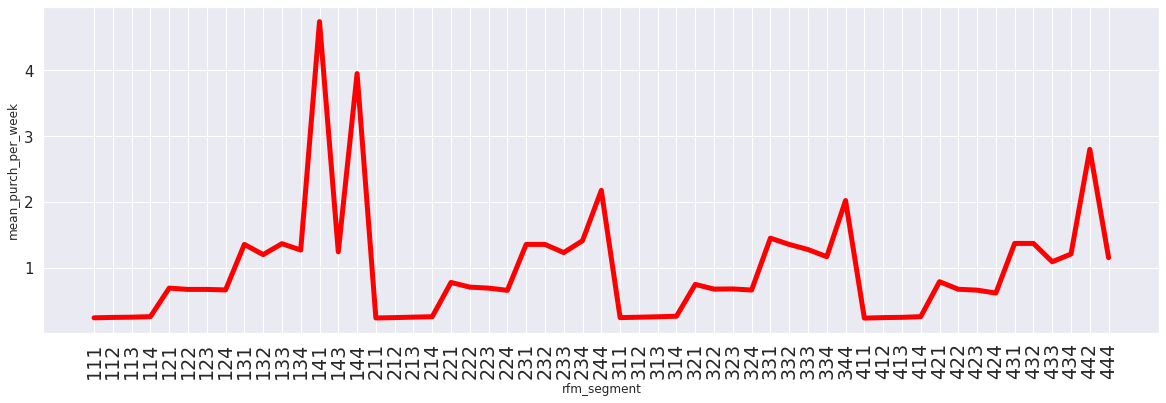

In [254]:
# график среднего покупок в неделю

sns.set(rc={"figure.figsize":(20, 6)})
sns.set(style="darkgrid")
plt.xticks(rotation=90, ha='center')
plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
sns.lineplot(x='rfm_segment', y='mean_purch_per_week', data=summary, color='red', linewidth=5) 

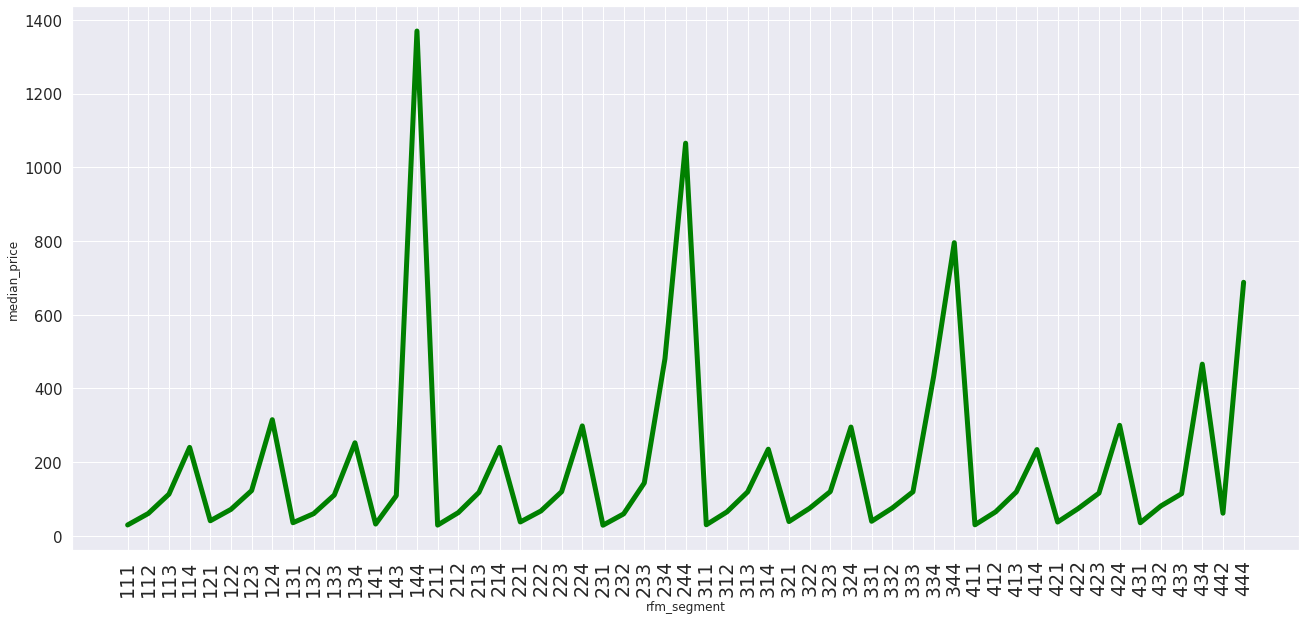

In [255]:
# график потраченной суммы

sns.set(rc={"figure.figsize":(22, 10)})
sns.set(style="darkgrid")
plt.xticks(rotation=90, ha='center')
plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
sns.lineplot(x='rfm_segment', y='median_price', data=summary, color='green', linewidth=5) 